
# IFN580 – Assignment 1: Starter Notebook


## 1) Config & Imports

In [1]:
# 1) Config & Imports
RANDOM_STATE = 42
TARGET_COL = "IsBadBuy"  # change if your target column differs
!pip install imblearn

import os, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# Ensure inline plots in classic Notebook
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imblearn]


## 2) Load Data

In [3]:
# 2) Load Data (robust search + sentinel handling)
DATA_PATHS = [
    "data/kick.csv",
    "kick.csv",
    "assignment 1 data kick.csv",
    "./data/kick.csv",
]

def find_data(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

DATA_PATH = find_data(DATA_PATHS)
if DATA_PATH is None:
    raise FileNotFoundError("CSV not found. Put your dataset as 'data/kick.csv' or update DATA_PATHS.")

print(f"Using data at: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)

# Turn '?' into NaN so imputers treat them as missing
df.replace('?', np.nan, inplace=True)

print(df.shape)
display(df.head(3))

Using data at: kick.csv
(41476, 31)


,PurchaseID,PurchaseTimestamp,PurchaseDate,Auction,VehYear,Make,Color,Transmission,WheelTypeID,WheelType,...,MMRCurrentRetailCleanPrice,MMRCurrentRetailRatio,PRIMEUNIT,AUCGUART,VNST,VehBCost,IsOnlineSale,WarrantyCost,ForSale,IsBadBuy
0,0,1253232000,18/09/2009 10:00,OTHER,2008.0,DODGE,RED,AUTO,2,Covers,...,12505,0.941783287,NaN,NaN,NC,7800,0.0,920.0,Yes,0
1,1,1253232000,18/09/2009 10:00,OTHER,2008.0,DODGE,RED,AUTO,2,Covers,...,10571,0.922618485,NaN,NaN,NC,7800,0.0,834.0,Yes,0
2,2,1253232000,18/09/2009 10:00,OTHER,2008.0,CHRYSLER,SILVER,AUTO,2,Covers,...,9932,0.935159082,NaN,NaN,NC,7800,0.0,834.0,Yes,0



## 3) Quick Audit



In [4]:
# 3) Quick Audit + numeric coercion (promote numeric-like object columns)

# Convert object columns that look numeric into real numbers (heuristic)
coerced = []
for c in df.columns:
    if c == TARGET_COL:  # don't touch the target
        continue
    s = pd.to_numeric(df[c], errors="coerce")
    # treat as numeric if majority converts and at least some support
    if (s.notna().mean() > 0.6) and (s.notna().sum() > 100):
        df[c] = s
        coerced.append(c)
print("Coerced to numeric:", len(coerced), "| sample:", coerced[:8])

# Basic info for Task 1 evidence
display(df.info())
print("Target counts (before):")
display(df[TARGET_COL].value_counts(dropna=False))
print("Target ratio (before):")
display(df[TARGET_COL].value_counts(normalize=True))

Coerced to numeric: 17 | sample: ['PurchaseID', 'PurchaseTimestamp', 'VehYear', 'WheelTypeID', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41476 entries, 0 to 41475
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PurchaseID                         41476 non-null  int64  
 1   PurchaseTimestamp                  41476 non-null  int64  
 2   PurchaseDate                       41476 non-null  object 
 3   Auction                            41432 non-null  object 
 4   VehYear                            41432 non-null  float64
 5   Make                               41432 non-null  object 
 6   Color                              41426 non-null  object 
 7   Transmission                       41426 non-null  object 
 8   WheelTypeID                      

None

Target counts (before):


IsBadBuy
0    36105
1     5371
Name: count, dtype: int64

Target ratio (before):


IsBadBuy
0    0.870503
1    0.129497
Name: proportion, dtype: float64

## 4)Train/Test Split (stratified)

In [5]:
# 4) Train/Test Split (stratified) and drop non-predictive columns
drop_cols = [c for c in ["PurchaseID", "PurchaseDate"] if c in df.columns]  # keep PurchaseTimestamp

y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL] + drop_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train/Test sizes:", X_train.shape, X_test.shape)

Train/Test sizes: (33180, 28) (8296, 28)


## 5) Preprocessing Pipeline (ColumnTransformer)

In [6]:
# 5) Preprocessing Pipeline (ColumnTransformer) – sklearn-version safe

# Identify feature types
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.columns.difference(numeric_features).tolist()

# Numeric: impute median then standardize (dense)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical: impute mode then One-Hot Encode
# Guard for sklearn param rename: 'sparse' (old) -> 'sparse_output' (new)
try:
    _ = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

Numeric features: 16
Categorical features: 12


## task2

In [7]:
#1a

# Instantiate the model
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Create a pipeline that first preprocesses the data and then trains the model
dt_pipeline = Pipeline(steps=[('preprocessor', preprocess),
                              ('classifier', dt_model)])

# Train the pipeline
dt_pipeline.fit(X_train, y_train)

# Access the parameters of the trained Decision Tree model from the pipeline
dt_params = dt_pipeline.named_steps['classifier'].get_params()

# Display the parameters
print("Decision Tree Model Parameters:")
for param, value in dt_params.items():
    print(f"{param}: {value}")

Decision Tree Model Parameters:
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
random_state: 42
splitter: best


In [8]:
#1bParameters used for the train/test split
test_size = 0.2
random_state = RANDOM_STATE # From the initial config cell
stratify = y # The target variable

print(f"Test set size: {test_size}")
print(f"Random state: {random_state}")
print(f"Stratification used: {stratify.name}")

Test set size: 0.2
Random state: 42
Stratification used: IsBadBuy


In [9]:
#1c
from sklearn.metrics import accuracy_score

# Predict on the training data
y_train_pred = dt_pipeline.predict(X_train)

# Calculate training accuracy
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc:.4f}")

# Predict on the test data
y_test_pred = dt_pipeline.predict(X_test)

# Calculate test accuracy
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 0.9998
Test Accuracy: 0.7923


In [10]:
#1e Get the trained Decision Tree model from the pipeline
tree_model = dt_pipeline.named_steps['classifier']

# Get the feature names after preprocessing
preprocessor = dt_pipeline.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# Get the feature index for the root node (first split)
first_split_feature_index = tree_model.tree_.feature[0]
first_split_feature_name = feature_names[first_split_feature_index]

print(f"The variable used for the first split is: {first_split_feature_name}")
print("\nVariables used for splits at the second level:")

# Get the children of the root node (nodes at the second level)
root_node_left_child = tree_model.tree_.children_left[0]
root_node_right_child = tree_model.tree_.children_right[0]

second_level_nodes = []
if root_node_left_child != -1:
    second_level_nodes.append(root_node_left_child)
if root_node_right_child != -1:
    second_level_nodes.append(root_node_right_child)


for node_index in second_level_nodes:
    # Check if the node is a split node (not a leaf node)
    if tree_model.tree_.children_left[node_index] != -1 or tree_model.tree_.children_right[node_index] != -1:
        feature_index = tree_model.tree_.feature[node_index]
        feature_name = feature_names[feature_index]
        print(f"- Node {node_index}: {feature_name}")
    else:
        print(f"- Node {node_index}: (This is a leaf node, no split)")

The variable used for the first split is: VehYear

Variables used for splits at the second level:
- Node 1: VehBCost
- Node 3104: WheelType_Alloy


In [11]:
#1d Get the number of nodes
n_nodes = tree_model.tree_.node_count

# Get the number of rules (leaf nodes)
# A node is a leaf node if its left and right children are both -1
leaf_nodes = tree_model.tree_.children_left == tree_model.tree_.children_right
n_rules = np.sum(leaf_nodes)

print(f"Number of nodes in the Decision Tree: {n_nodes}")
print(f"Number of rules (leaf nodes) in the Decision Tree: {n_rules}")

Number of nodes in the Decision Tree: 8027
Number of rules (leaf nodes) in the Decision Tree: 4014


In [12]:
#1fGet the feature importances
importances = tree_model.feature_importances_

# Create a pandas Series for easier sorting
feature_importances = pd.Series(importances, index=feature_names)

# Get the top 5 most important features
top_5_features = feature_importances.nlargest(5)

print("Top 5 most important variables in building the tree:")
print(top_5_features)

Top 5 most important variables in building the tree:
VehBCost                           0.087561
MMRCurrentRetailRatio              0.079209
PurchaseTimestamp                  0.072258
VehOdo                             0.072072
MMRAcquisitionAuctionCleanPrice    0.048230
dtype: float64


In [13]:
#1g
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
overfitting_threshold = 0.10  # You can adjust this threshold

if (train_acc - test_acc) > overfitting_threshold:
    print("\nEvidence of potential overfitting: Training accuracy is significantly higher than test accuracy.")
else:
    print("\nNo strong evidence of overfitting based on the difference between training and test accuracy (within the set threshold).")

Training Accuracy: 0.9998
Test Accuracy: 0.7923

Evidence of potential overfitting: Training accuracy is significantly higher than test accuracy.


In [14]:
#2a
param_grid = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 10, 20],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# Instantiate GridSearchCV
# cv=5 means 5-fold cross-validation
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
print("Performing Grid Search...")
grid_search.fit(X_train, y_train)

print("Grid Search complete.")

# Get the best parameters
best_params = grid_search.best_params_
print("\nOptimal parameters found by GridSearchCV:")
print(best_params)

# Get the best performing model
best_dt_model = grid_search.best_estimator_

Performing Grid Search...
Grid Search complete.

Optimal parameters found by GridSearchCV:
{'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 20}


In [15]:
#2b
from sklearn.metrics import accuracy_score

# Predict on the training data
y_train_pred = grid_search.predict(X_train)

# Calculate training accuracy
train_acc_ = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc_:.4f}")

# Predict on the test data
y_test_pred = grid_search.predict(X_test)

# Calculate test accuracy
test_acc_ = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc_:.4f}")

Training Accuracy: 0.8873
Test Accuracy: 0.8558


In [16]:
#2c
# Access the classifier and preprocessor inside the pipeline
tree_model_   = best_dt_model.named_steps['classifier']
preprocessor_ = best_dt_model.named_steps['preprocessor']

# Get feature names after preprocessing
try:
    feature_names = preprocessor_.get_feature_names_out()
except Exception:
    # fallback if get_feature_names_out not available
    num_names = preprocessor.transformers_[0][2]  # numeric features
    cat_enc   = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_names = list(cat_enc.get_feature_names_out(preprocessor.transformers_[1][2]))
    feature_names = np.array(num_names + cat_names)

# Tree stats
n_nodes = tree_model_.tree_.node_count
leaf_nodes = tree_model_.tree_.children_left == tree_model_.tree_.children_right
n_rules = np.sum(leaf_nodes)

print(f"Number of nodes in the Decision Tree: {n_nodes}")
print(f"Number of rules (leaf nodes) in the Decision Tree: {n_rules}")


Number of nodes in the Decision Tree: 711
Number of rules (leaf nodes) in the Decision Tree: 356


In [17]:
#2d
first_split_feature_index = tree_model_.tree_.feature[0]
first_split_feature_name = feature_names[first_split_feature_index]

print(f"The variable used for the first split is: {first_split_feature_name}")
print("\nVariables used for splits at the second level:")

# Get the children of the root node (nodes at the second level)
root_node_left_child = tree_model_.tree_.children_left[0]
root_node_right_child = tree_model_.tree_.children_right[0]

second_level_nodes = []
if root_node_left_child != -1:
    second_level_nodes.append(root_node_left_child)
if root_node_right_child != -1:
    second_level_nodes.append(root_node_right_child)


for node_index in second_level_nodes:
    # Check if the node is a split node (not a leaf node)
    if tree_model_.tree_.children_left[node_index] != -1 or tree_model_.tree_.children_right[node_index] != -1:
        feature_index = tree_model_.tree_.feature[node_index]
        feature_name = feature_names[feature_index]
        print(f"- Node {node_index}: {feature_name}")
    else:
        print(f"- Node {node_index}: (This is a leaf node, no split)")

The variable used for the first split is: VehYear

Variables used for splits at the second level:
- Node 1: VehBCost
- Node 376: WheelType_Alloy


In [18]:
#2eGet the feature importances
importances = tree_model_.feature_importances_

# Create a pandas Series for easier sorting
feature_importances = pd.Series(importances, index=feature_names)

# Get the top 5 most important features
top_5_features = feature_importances.nlargest(5)

print("Top 5 most important variables in building the tree:")
print(top_5_features)

Top 5 most important variables in building the tree:
VehBCost                 0.133919
VehYear                  0.113611
PurchaseTimestamp        0.078293
VehOdo                   0.076172
MMRCurrentRetailRatio    0.061159
dtype: float64


In [19]:
#2f
print(f"Training Accuracy: {train_acc_:.4f}")
print(f"Test Accuracy: {test_acc_:.4f}")
overfitting_threshold = 0.10  # You can adjust this threshold

if (train_acc_ - test_acc_) > overfitting_threshold:
    print("\nEvidence of potential overfitting: Training accuracy is significantly higher than test accuracy.")
else:
    print("\nNo strong evidence of overfitting based on the difference between training and test accuracy (within the set threshold).")

Training Accuracy: 0.8873
Test Accuracy: 0.8558

No strong evidence of overfitting based on the difference between training and test accuracy (within the set threshold).


Default DT AUC: 0.5622
GridSearchCV DT AUC: 0.6600


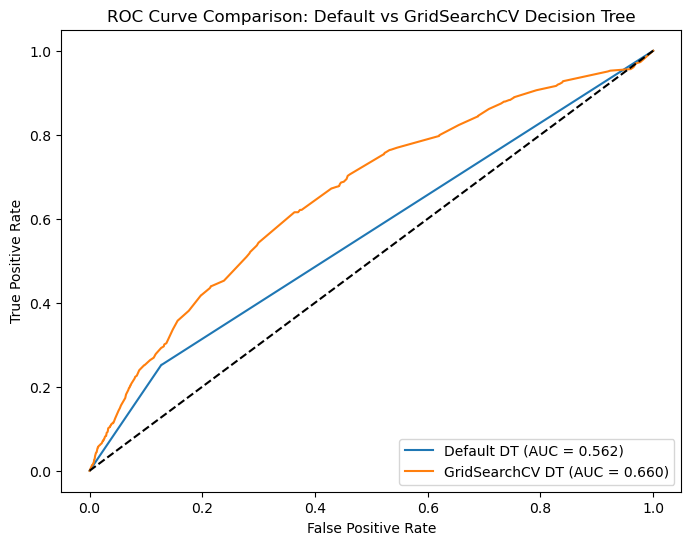

In [20]:
#3
from sklearn.metrics import roc_curve, roc_auc_score
# Probabilities for ROC curve
y_test_proba_default = dt_pipeline.predict_proba(X_test)[:, 1]
y_test_proba_grid = best_dt_model.predict_proba(X_test)[:, 1]

# Compute ROC curves and AUC
fpr_default, tpr_default, _ = roc_curve(y_test, y_test_proba_default)
auc_default = roc_auc_score(y_test, y_test_proba_default)

fpr_grid, tpr_grid, _ = roc_curve(y_test, y_test_proba_grid)
auc_grid = roc_auc_score(y_test, y_test_proba_grid)

print(f"Default DT AUC: {auc_default:.4f}")
print(f"GridSearchCV DT AUC: {auc_grid:.4f}")

# Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_default, tpr_default, label=f"Default DT (AUC = {auc_default:.3f})")
plt.plot(fpr_grid, tpr_grid, label=f"GridSearchCV DT (AUC = {auc_grid:.3f})")
plt.plot([0,1], [0,1], 'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Default vs GridSearchCV Decision Tree")
plt.legend(loc="lower right")
plt.show()


In [21]:
#4
# Get the classifier and preprocessor from the tuned pipeline
tree_model_best = best_dt_model.named_steps['classifier']
preprocessor_best = best_dt_model.named_steps['preprocessor']

# Get feature names after preprocessing
try:
    feature_names = preprocessor_best.get_feature_names_out()
except Exception:
    num_names = preprocessor_best.transformers_[0][2]
    cat_enc   = preprocessor_best.named_transformers_['cat'].named_steps['onehot']
    cat_names = list(cat_enc.get_feature_names_out(preprocessor_best.transformers_[1][2]))
    feature_names = np.array(num_names + cat_names)

# Get top 10 most important features
importances = tree_model_best.feature_importances_
feature_importances = pd.Series(importances, index=feature_names)
top_features = feature_importances.nlargest(10)

print("Top features that contribute to predicting 'kicks':")
print(top_features)


Top features that contribute to predicting 'kicks':
VehBCost                            0.133919
VehYear                             0.113611
PurchaseTimestamp                   0.078293
VehOdo                              0.076172
MMRCurrentRetailRatio               0.061159
WheelType_Alloy                     0.053961
MMRAcquisitionAuctionCleanPrice     0.044608
MMRAcquisitionRetailAveragePrice    0.039302
WarrantyCost                        0.038935
MMRAcquisitonRetailCleanPrice       0.030299
dtype: float64


In [22]:
# Reuse from Task 1: preprocess, X_train, X_test, y_train, y_test
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.feature_selection import RFE

# Fixed `RANDOM_STATE` for repeatable results.
RANDOM_STATE = 42

Best params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Train acc: 0.8707655213984328
Test  acc: 0.8706605593056895

Confusion matrix:
 [[7221    1]
 [1072    2]]

Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      7222
           1       0.67      0.00      0.00      1074

    accuracy                           0.87      8296
   macro avg       0.77      0.50      0.47      8296
weighted avg       0.84      0.87      0.81      8296



,Feature,Coef,Abs
13,VehBCost,-0.311732,0.311732
1,VehYear,-0.309670,0.309670
8,MMRCurrentAuctionAveragePrice,0.270037,0.270037
11,MMRCurrentRetailCleanPrice,-0.268263,0.268263
129,WheelType_Covers,-0.261478,0.261478


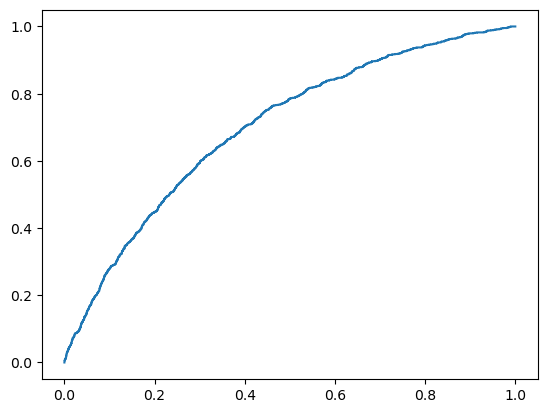

In [23]:
# Reusing Task-1 preprocessing in a single end-to-end pipeline
pipe_full = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Hyperparameter tuning: regularisation type & strength
# L1/L2 regularisations control sparsity vs ridge-style shrinkage
# Liblinear/saga support L1
param_grid_full = {
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "saga"],
}

# 5-fold CV tuned for accuracy
grid_full = GridSearchCV(pipe_full, param_grid_full, cv=5, scoring="accuracy", n_jobs=-1)
grid_full.fit(X_train, y_train)

# Predictions
ytr_pred_full = grid_full.predict(X_train)
yte_pred_full = grid_full.predict(X_test)

print("Best params:", grid_full.best_params_)
print("Train acc:", accuracy_score(y_train, ytr_pred_full))
print("Test  acc:", accuracy_score(y_test, yte_pred_full))
print("\nConfusion matrix:\n", confusion_matrix(y_test, yte_pred_full))
print("\nReport:\n", classification_report(y_test, yte_pred_full))

# Top 5 features
best_full = grid_full.best_estimator_
feat_names = best_full.named_steps["prep"].get_feature_names_out()
coefs = best_full.named_steps["clf"].coef_[0]
top5 = pd.DataFrame({"Feature": feat_names, "Coef": coefs, "Abs": np.abs(coefs)}).sort_values("Abs", ascending=False).head(5)
display(top5)

# Using predicted probabilities to compute ROC/AUC
yprob_full = best_full.predict_proba(X_test)[:,1]
fpr_full, tpr_full, _ = roc_curve(y_test, yprob_full)
auc_full = auc(fpr_full, tpr_full)
plt.plot(fpr_full, tpr_full, label=f"Full (AUC={auc_full:.3f})")

In [ ]:
# Base estimator is used by RFE to score feature usefulness
base_lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, solver="liblinear", penalty="l2")

pipe_rfe = Pipeline([
    ("prep", preprocess),
    ("rfe", RFE(base_lr, n_features_to_select=50, step=0.1)),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Hyperparameters to tune:
# How many features RFE should keep
# Logistic penalty type & regularisation strength (C)
# Compatible solvers
param_grid_rfe = {
    "rfe__n_features_to_select": [30, 50, 80],
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "saga"],
}

# 5-fold CV tuned for accuracy
grid_rfe = GridSearchCV(pipe_rfe, param_grid_rfe, cv=5, scoring="accuracy", n_jobs=-1)
grid_rfe.fit(X_train, y_train)

# Predictions
ytr_pred_rfe = grid_rfe.predict(X_train)
yte_pred_rfe = grid_rfe.predict(X_test)

print("Best params (RFE):", grid_rfe.best_params_)
print("Train acc:", accuracy_score(y_train, ytr_pred_rfe))
print("Test  acc:", accuracy_score(y_test, yte_pred_rfe))

# Plotting the ROC curve
best_rfe = grid_rfe.best_estimator_
yprob_rfe = best_rfe.predict_proba(X_test)[:,1]
fpr_rfe, tpr_rfe, _ = roc_curve(y_test, yprob_rfe)
auc_rfe = auc(fpr_rfe, tpr_rfe)
plt.plot(fpr_rfe, tpr_rfe, label=f"RFE (AUC={auc_rfe:.3f})")

# Plotting the diagonal reference and finalising the ROC figure
plt.plot([0,1],[0,1],"--")
plt.legend(); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves Logistic Regression"); plt.show()

# Checking overfitting (comparing train vs test accuracy gaps)
gap_full = accuracy_score(y_train, ytr_pred_full) - accuracy_score(y_test, yte_pred_full)
gap_rfe  = accuracy_score(y_train, ytr_pred_rfe) - accuracy_score(y_test, yte_pred_rfe)
print("Overfitting gap (Full):", gap_full)
print("Overfitting gap (RFE):", gap_rfe)

In [ ]:
# Selecting the better model by test accuracy
# If RFE model tests are atleast as good as the Full model, we will prefer RFE for simplicity
use_rfe = accuracy_score(y_test, yte_pred_rfe) >= accuracy_score(y_test, yte_pred_full)
chosen = best_rfe if use_rfe else best_full
model_name = "RFE" if use_rfe else "Full"

# Getting the post processing feature names, if RFE is better we keep a subset
feat_names_all = chosen.named_steps["prep"].get_feature_names_out()
if "rfe" in chosen.named_steps:
    mask = chosen.named_steps["rfe"].support_
    feat_names = feat_names_all[mask]
else:
    feat_names = feat_names_all

# Coefficients from the final LR
coefs = chosen.named_steps["clf"].coef_.ravel()
print(f"{model_name} features: {len(feat_names)}, coefficients: {len(coefs)}")

coef_df = (pd.DataFrame({"Feature": feat_names, "Coef": coefs})
             .assign(Abs=lambda d: d["Coef"].abs())
             .sort_values("Abs", ascending=False))
top10 = coef_df.head(10)

print("Top contributors from", model_name)
display(top10)

# Positive coef means higher odds of IsBadBuy=1, negative coef means lower odds
print("Positive coef -> higher odds of IsBadBuy=1 (likely kick); Negative -> lower odds.")
print("Note: one-hot effects are relative to the baseline category.")